In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yap15-heart-diseases-predictions/sample_submission.csv
/kaggle/input/yap15-heart-diseases-predictions/train.csv
/kaggle/input/yap15-heart-diseases-predictions/test.csv


In [2]:
#!pip install pandas-profiling[notebook]

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

import pandas_profiling

from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from pickle import dump,load

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from pandas_profiling import ProfileReport

In [4]:
df = pd.read_csv("/kaggle/input/yap15-heart-diseases-predictions/train.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile

In [7]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Очевидны неверные данные в признаках **height** **weight** **ap_hi** **ap_lo**, В чем измеряется **cholesterol** **gluc** я не знаю, но переменные категориальные, оставим как есть, остальное почистим, а вес округлим до целого и переведем в int

In [8]:
df.weight = np.round(df.weight).astype(int)

Признак **id** совершенно излишний для обучения модели, а возраст логичнее перевести в года, с учетом того что в **streamlit** неудобно будет отмерять возраст в днях.

In [9]:
df['age_year'] = round(df.age/365).astype(int)

In [10]:
df = df.drop(['id','age'], axis=1)

In [11]:
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year
0,2,168,62,110,80,1,1,0,0,1,0,50
1,1,156,85,140,90,3,1,0,0,1,1,55
2,1,165,64,130,70,3,1,0,0,0,1,52
3,2,169,82,150,100,1,1,0,0,1,1,48
4,1,156,56,100,60,1,1,0,0,0,0,48


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   gender       70000 non-null  int64
 1   height       70000 non-null  int64
 2   weight       70000 non-null  int64
 3   ap_hi        70000 non-null  int64
 4   ap_lo        70000 non-null  int64
 5   cholesterol  70000 non-null  int64
 6   gluc         70000 non-null  int64
 7   smoke        70000 non-null  int64
 8   alco         70000 non-null  int64
 9   active       70000 non-null  int64
 10  cardio       70000 non-null  int64
 11  age_year     70000 non-null  int64
dtypes: int64(12)
memory usage: 6.4 MB


In [13]:
df.columns

Index(['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
       'smoke', 'alco', 'active', 'cardio', 'age_year'],
      dtype='object')

Теперь внимательно посмотрим на "несуразности"

In [14]:
df.height.quantile([0,0.005,0.01,0.25,0.5,0.75,0.99,0.9999,1])

0.0000     55.0
0.0050    144.0
0.0100    147.0
0.2500    159.0
0.5000    165.0
0.7500    170.0
0.9900    184.0
0.9999    198.0
1.0000    250.0
Name: height, dtype: float64

In [15]:
df.weight.quantile([0,0.005,0.01,0.25,0.5,0.75,0.99,0.9999,1])

0.0000     10.0
0.0050     45.0
0.0100     48.0
0.2500     65.0
0.5000     72.0
0.7500     82.0
0.9900    117.0
0.9999    180.0
1.0000    200.0
Name: weight, dtype: float64

In [16]:
df.ap_hi.quantile([0,0.01,0.25,0.5,0.75,0.99,1])

0.00     -150.0
0.01       90.0
0.25      120.0
0.50      120.0
0.75      140.0
0.99      180.0
1.00    16020.0
Name: ap_hi, dtype: float64

In [17]:
df.ap_lo.quantile([0,0.01,0.25,0.5,0.75,0.98,0.985,0.99,1])

0.000      -70.00
0.010       60.00
0.250       80.00
0.500       80.00
0.750       90.00
0.980      110.00
0.985      126.06
0.990     1000.00
1.000    11000.00
Name: ap_lo, dtype: float64

Устраним безобразие и установим следующие диапазоны в данных:
- **height**    144 - 200
- **weight**    45-180
-  **ap_hi**    90 - 180
-  **ap_lo**    60 - 120

Предположим что  верхнее давление выше нихнего, предполагая, что остальные пациенты жить уже  не могут

[Если разрыв составляет менее 30 мм, это повод бить тревогу.](https://sim-portal.ru/raznitsa-mezhdu-verhnim-i-nizhnim-davleniem-vse-chto-nuzhno-znat/#:~:text=%D0%95%D1%81%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B7%D1%80%D1%8B%D0%B2%20%D1%81%D0%BE%D1%81%D1%82%D0%B0%D0%B2%D0%BB%D1%8F%D0%B5%D1%82,%D0%B4%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%20%D0%BD%D0%B5%D0%BB%D1%8C%D0%B7%D1%8F%20%D0%B8%D0%B3%D0%BD%D0%BE%D1%80%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D1%82%D1%8C.)


In [18]:
df_clearn = df.query("(45<= weight <= 180) and (144<= height  <= 200) \
                     and (90<= ap_hi <= 180) and (60 <= ap_lo <= 120)\
                     and ap_lo < ap_hi")

df_clearn = df.query("(45<= weight <= 180) and (144<= height  <= 200) \
                     and (90<= ap_hi <= 180) and (60 <= ap_lo <= 120)")

df_clearn.query("((ap_hi- ap_lo) <= 15) and (cardio == 1)")

In [19]:
#Потеряли 2356 строк, что вполне приемлемо
df_clearn.shape

(67644, 12)

In [20]:
df_clearn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67644 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   gender       67644 non-null  int64
 1   height       67644 non-null  int64
 2   weight       67644 non-null  int64
 3   ap_hi        67644 non-null  int64
 4   ap_lo        67644 non-null  int64
 5   cholesterol  67644 non-null  int64
 6   gluc         67644 non-null  int64
 7   smoke        67644 non-null  int64
 8   alco         67644 non-null  int64
 9   active       67644 non-null  int64
 10  cardio       67644 non-null  int64
 11  age_year     67644 non-null  int64
dtypes: int64(12)
memory usage: 6.7 MB


In [21]:
df_clearn.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_year
0,2,168,62,110,80,1,1,0,0,1,0,50
1,1,156,85,140,90,3,1,0,0,1,1,55
2,1,165,64,130,70,3,1,0,0,0,1,52
3,2,169,82,150,100,1,1,0,0,1,1,48
4,1,156,56,100,60,1,1,0,0,0,0,48


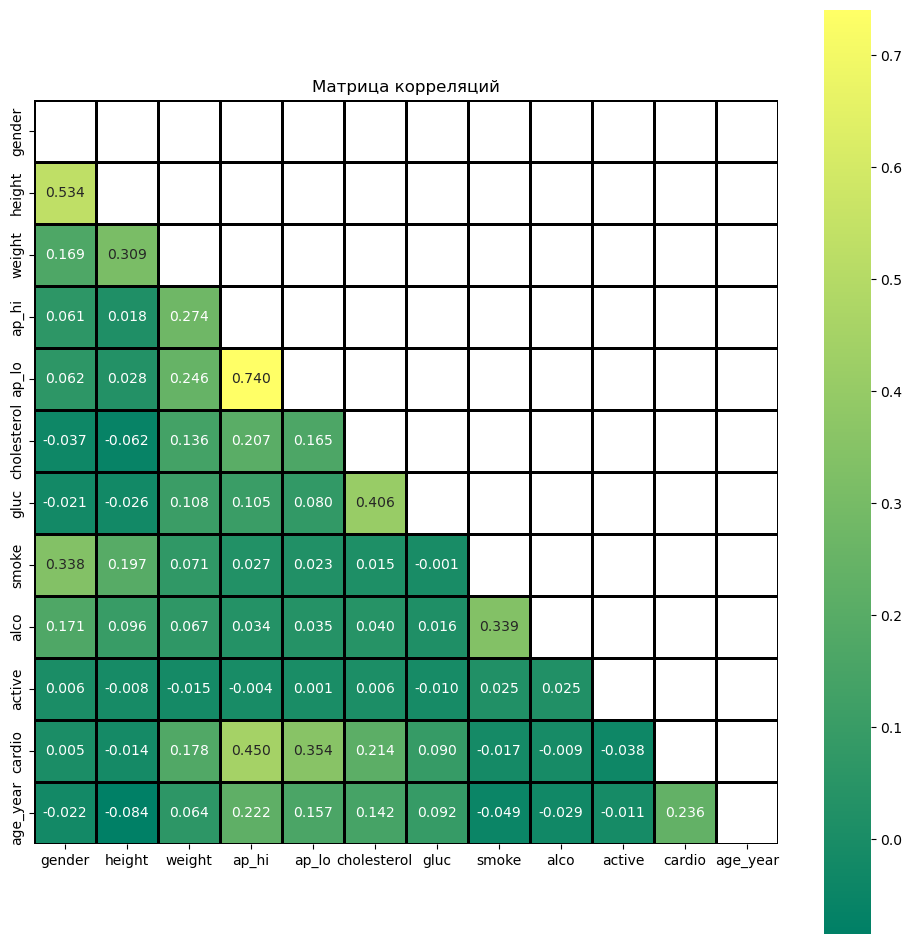

In [22]:
fig, ax = plt.subplots(figsize = (12,12))
ax = sns.heatmap(data = df_clearn.corr(method = 'spearman'), annot =True, square= True,
                 cmap='summer', fmt = '.3f', linewidths=1, linecolor = 'black',
                 mask=np.triu(df_clearn.corr()))
plt.title('Матрица корреляций')
plt.show()

In [23]:
X_train = df_clearn.drop('cardio', axis = 1)
y_train = df_clearn.cardio

In [24]:
X_train.shape, y_train.shape

((67644, 11), (67644,))

In [25]:
def model_work(clf, param, X_train, y_train):
    gscv = GridSearchCV(clf, param, cv=5, scoring='roc_auc')
    gscv.fit(X_train,y_train)
    best_est = gscv.best_estimator_
    best_params = gscv.best_params_
    #y_pred = best_est.predict(X_train)
    best_roc_auc = gscv.best_score_
       
    return  best_roc_auc, best_params, best_est

In [26]:
%%time
clf_dtc = DecisionTreeClassifier(random_state = 42, class_weight='balanced' )
param_dtc = {'criterion' : ['gini', 'entropy'], 'max_depth':range(1,15),}
result_dtc = model_work(clf_dtc, param_dtc, X_train, y_train)

CPU times: user 20.3 s, sys: 6.33 ms, total: 20.3 s
Wall time: 20.3 s


In [27]:
result_dtc

(0.7923319741189544,
 {'criterion': 'entropy', 'max_depth': 6},
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_depth=6, random_state=42))

(0.7923480606840139,
 {'criterion': 'entropy', 'max_depth': 6},
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_depth=6, random_state=42))

In [28]:
%%time
clf_rfc = RandomForestClassifier(random_state = 42, class_weight='balanced')
param_rfc = {'n_estimators': range (3, 37, 3), 'max_depth':range(1,20)}
result_rfc = model_work(clf_rfc, param_rfc, X_train, y_train)

CPU times: user 16min 4s, sys: 2.58 s, total: 16min 6s
Wall time: 16min 7s


Уж очень долго пересчитывает.. несколько раз считал, поэтому сразу обучу модель с параметрами (0.7989160697788671,
 {'max_depth': 9, 'n_estimators': 33},
 RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=33,
                        random_state=42))

In [29]:
result_rfc

(0.7989160697788671,
 {'max_depth': 9, 'n_estimators': 33},
 RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=33,
                        random_state=42))

(0.7957847488039275,
 {'max_depth': 8, 'n_estimators': 36},
 RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=36,
                        random_state=42))

In [30]:
result = {'DecisionTreeClassifier':result_dtc,
          'RandomForestClassifier':result_rfc}

result_df = pd.DataFrame(result, index=['best_roc_auc','Лучшие параметры','Лучшая модель'])
result_df.round(4)

,DecisionTreeClassifier,RandomForestClassifier
best_roc_auc,0.792332,0.798916
Лучшие параметры,"{'criterion': 'entropy', 'max_depth': 6}","{'max_depth': 9, 'n_estimators': 33}"
Лучшая модель,DecisionTreeClassifier(class_weight='balanced'...,"(DecisionTreeClassifier(max_depth=9, max_featu..."


	DecisionTreeClassifier	RandomForestClassifier
best_roc_auc	0.792348	0.799067
Лучшие параметры	{'criterion': 'entropy', 'max_depth': 6}	{'max_depth': 10, 'n_estimators': 36}
Лучшая модель	DecisionTreeClassifier(class_weight='balanced'...	(DecisionTreeClassifier(max_depth=10, max_feat...

%%time
model= RandomForestClassifier(n_estimators = 36, max_depth = 8,\
       random_state = 42, class_weight='balanced')
model.fit(X_train,y_train)

In [31]:
model = result_rfc[2]
model

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=33,
                       random_state=42)

In [32]:
X_test = pd.read_csv("/kaggle/input/yap15-heart-diseases-predictions/test.csv")

In [33]:
X_test['age_year'] = round(X_test.age/365).astype(int)

In [34]:
X_test_c = X_test.drop(['id','age'], axis=1)

In [35]:
X_predicted_test = model.predict_proba(X_test_c)


In [36]:
predicted_test = X_predicted_test[:,1]

In [37]:
predicted_test

array([0.49593242, 0.59225328, 0.39577256, ..., 0.44653672, 0.37277114,
       0.58079142])

In [38]:
submission = pd.DataFrame(columns = ['id','cardio'])

In [39]:
submission.id = X_test.id
submission.cardio = predicted_test

In [40]:
submission.head()

,id,cardio
0,5,0.495932
1,6,0.592253
2,7,0.395773
3,10,0.540937
4,11,0.217815


In [41]:
submission.to_csv('/kaggle/working/submission.csv',sep=',', index=False)

In [42]:
with open("../working/model2.pcl", "wb") as fid:
    pickle.dump(model, fid)

In [43]:
X_test_c.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_year
0,1,154,85.0,130,80,1,1,0,0,1,52
1,2,170,69.0,130,90,1,1,0,0,1,52
2,1,160,70.0,120,75,1,1,0,0,0,56
3,2,185,94.0,130,90,1,1,0,0,1,50
4,2,170,76.0,120,80,1,1,0,0,1,44
